In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2

import warnings
warnings.filterwarnings('ignore')

from PIL import Image
import tensorflow as tf

from sklearn.model_selection import train_test_split
from skimage.transform import resize
from sklearn.metrics import accuracy_score

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

In [2]:
# loading dataset
data = []
labels = []
classes = 43
cur_path = '../input/gtsrb-german-traffic-sign/Train'

for i in os.listdir(cur_path):
    dir = cur_path + '/' + i
    for j in os.listdir(dir):
        img_path = dir+'/'+j
        img = cv2.imread(img_path,-1)
        img = cv2.resize(img, (28,28), interpolation = cv2.INTER_NEAREST)
        data.append(img)
        labels.append(i)
        
data = np.array(data)
labels = np.array(labels)
print(data.shape, labels.shape)

(39209, 28, 28, 3) (39209,)


In [20]:
import numpy as np
x_train = np.array(data)
y_train = np.array(labels)

In [21]:
x_train = x_train / 127.5 - 1

In [22]:
#x_train = x_train.reshape(-1, 2700)
x_train.shape

(39209, 28, 28, 3)

In [24]:
from tensorflow.keras.layers import Dense, LeakyReLU, Dropout, Input, Reshape
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.models import Sequential, Model
from keras.layers.convolutional import UpSampling2D, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
import numpy as np
import matplotlib.pyplot as plt

# gan에 입력되는 noise에 대한 dimension
NOISE_DIM = 100

# adam optimizer 정의, learning_rate = 0.0002, beta_1로 줍니다.
# Vanilla Gan과 DCGAN에서 이렇게 셋팅을 해주는데
# 이렇게 해줘야 훨씬 학습을 잘합니다.
adam = Adam(lr=0.0002, beta_1=0.5)

In [25]:
generator = Sequential([
    Dense(128 * 7 * 7, activation="relu", input_shape=(NOISE_DIM,)), 
    Reshape((7, 7, 128)), 
    
    BatchNormalization(momentum=0.8), # what is batch normalization?? 
    UpSampling2D(), # what is upsampling?? 
    Conv2D(128, kernel_size=3, padding="same"),
    Activation("relu"), 
    
    BatchNormalization(momentum=0.8), 
    UpSampling2D(), 
    Conv2D(64, kernel_size=3, padding="same"), 
    Activation("relu"), 
    
    BatchNormalization(momentum=0.8), 
    Conv2D(3, kernel_size=3, padding="same"), 
    Activation("tanh"), 
])

In [26]:
generator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 128)       147584    
_________________________________________________________________
activation_3 (Activation)    (None, 14, 14, 128)       0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 14, 14, 128)      

In [27]:
discriminator = Sequential([
    Conv2D(32, kernel_size=3, strides=2, input_shape=(28, 28, 3), padding="same"), 
    LeakyReLU(alpha=0.2), 
    Dropout(0.25), 
    
    Conv2D(64, kernel_size=3, strides=2, padding="same"), 
    ZeroPadding2D(padding=((0,1),(0,1))), 
    LeakyReLU(alpha=0.2), 
    Dropout(0.25), 
    BatchNormalization(momentum=0.8), 
    
    Conv2D(128, kernel_size=3, strides=2, padding="same"), 
    LeakyReLU(alpha=0.2), 
    Dropout(0.25), 
    BatchNormalization(momentum=0.8), 
    
    Conv2D(256, kernel_size=3, strides=1, padding="same"), 
    LeakyReLU(alpha=0.2), 
    Dropout(0.25), 
    Flatten(), 
    Dense(1, activation='sigmoid'), 
])

In [28]:
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 14, 14, 32)        896       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 8, 8, 64)          0         
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 8, 8, 64)         

In [29]:
# 반드시 dicriminator를 compile 해주어야 합니다.
discriminator.compile(loss='binary_crossentropy', optimizer=adam)

In [30]:
# generator와 discriminator를 연결합니다.

# discriminator는 학습을 하지 않도록 하며, Gan 모델에서는 generator만 학습하도록 합니다.
discriminator.trainable = False

gan_input = Input(shape=(NOISE_DIM,))
x = generator(inputs=gan_input)
output = discriminator(x)

# gan 모델을 정의합니다.
gan = Model(gan_input, output)

In [31]:
gan.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 28, 28, 3)         857859    
_________________________________________________________________
sequential_3 (Sequential)    (None, 1)                 393281    
Total params: 1,251,140
Trainable params: 857,219
Non-trainable params: 393,921
_________________________________________________________________


In [32]:
gan.compile(loss='binary_crossentropy', optimizer=adam)

In [33]:
def get_batches(data, batch_size):
    batches = []
    for i in range(int(data.shape[0] // batch_size)): # 60000 // 128 = 468
        batch = data[i * batch_size: (i + 1) * batch_size] # x_train[0 : 128], x_train[128 : 256], x_train[256 : 384]...
        batches.append(batch)
    return np.asarray(batches) # x_train을 0~127, 128-255 식으로 리턴

In [34]:
def visualize_training(epoch, d_losses, g_losses):
    # 오차에 대한 시각화
    plt.figure(figsize=(8, 4))
    plt.plot(d_losses, label='Discriminator Loss')
    plt.plot(g_losses, label='Generatror Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    print('epoch: {}, Discriminator Loss: {}, Generator Loss: {}'.format(epoch, np.asarray(d_losses).mean(), np.asarray(g_losses).mean()))
    
    #샘플 데이터 생성 후 시각화
    noise = np.random.normal(0, 1, size=(24, NOISE_DIM))
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(-1, 28, 28, 3)
    
    plt.figure(figsize=(8, 4))
    for i in range(generated_images.shape[0]):
        plt.subplot(4, 6, i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [16]:
BATCH_SIZE = 128
EPOCHS= 50

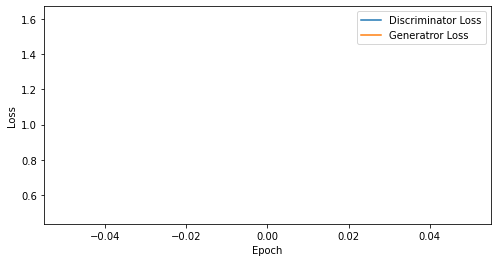

epoch: 1, Discriminator Loss: 0.49229347705841064, Generator Loss: 1.6159799098968506


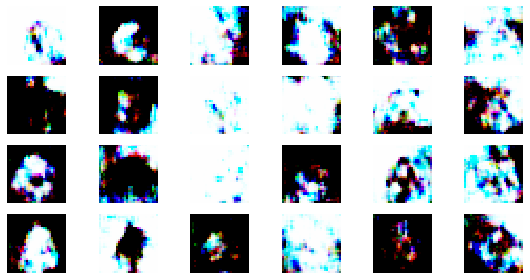

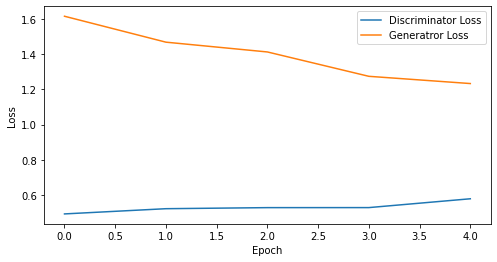

epoch: 5, Discriminator Loss: 0.5297625422477722, Generator Loss: 1.4010808229446412


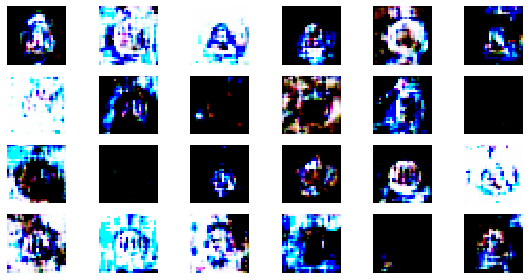

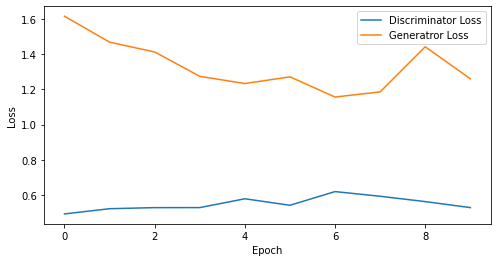

epoch: 10, Discriminator Loss: 0.5492508113384247, Generator Loss: 1.3322757244110108


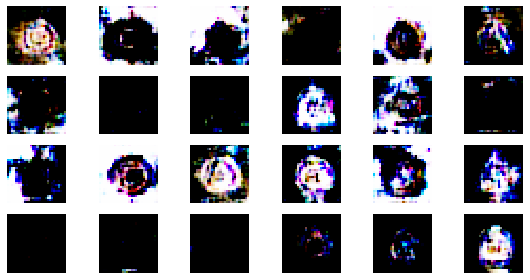

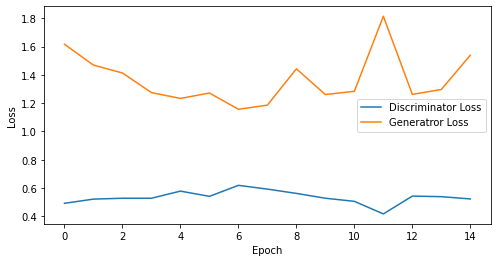

epoch: 15, Discriminator Loss: 0.5347691555817922, Generator Loss: 1.3678148587544758


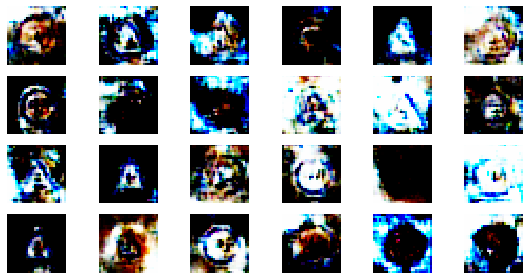

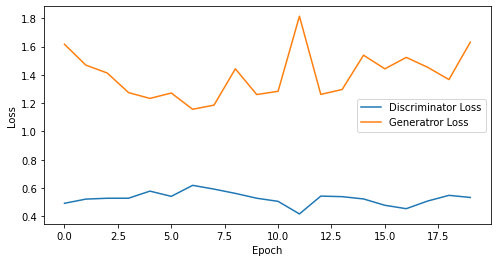

epoch: 20, Discriminator Loss: 0.5272180318832398, Generator Loss: 1.396697473526001


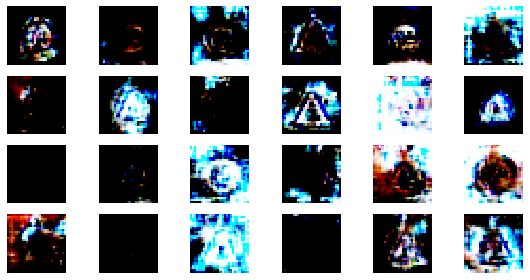

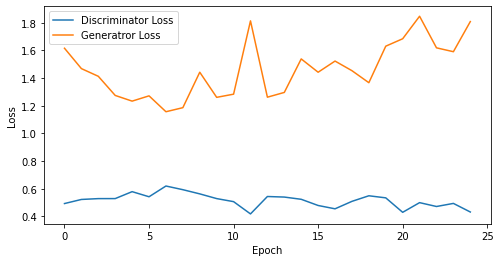

epoch: 25, Discriminator Loss: 0.5147061848640442, Generator Loss: 1.459387068748474


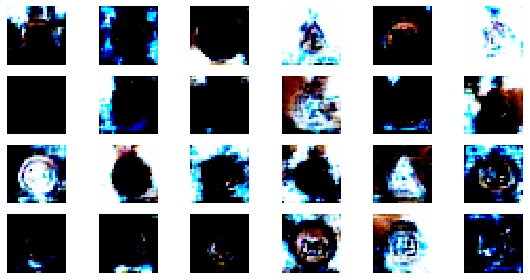

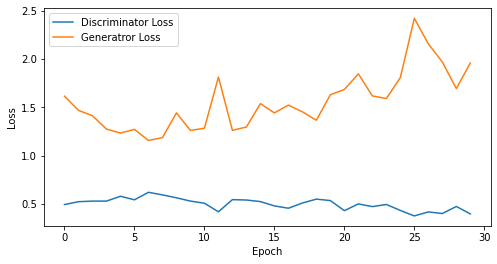

epoch: 30, Discriminator Loss: 0.49750027656555174, Generator Loss: 1.5563662767410278


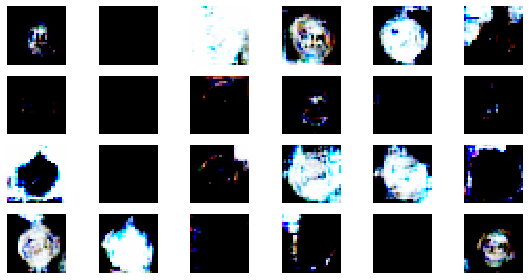

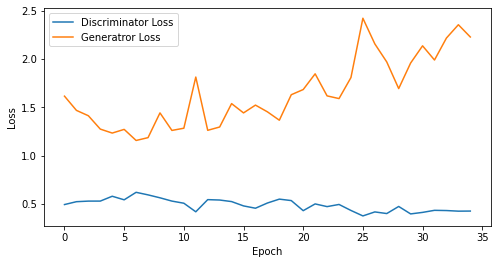

epoch: 35, Discriminator Loss: 0.48706807579313005, Generator Loss: 1.6463865382330758


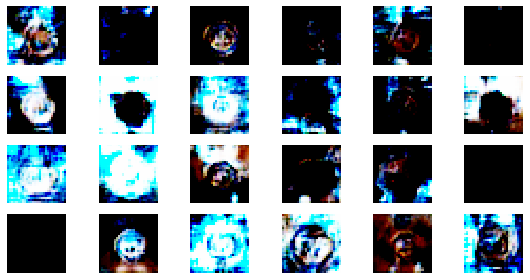

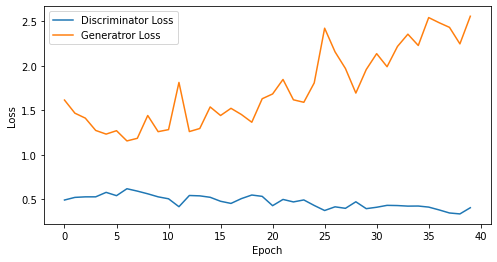

epoch: 40, Discriminator Loss: 0.4732544168829918, Generator Loss: 1.7472750931978225


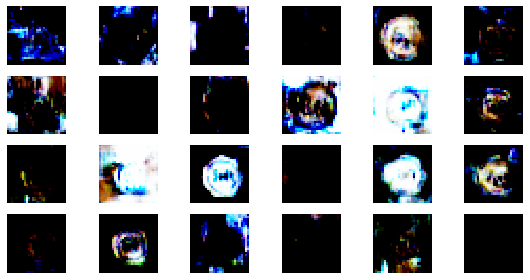

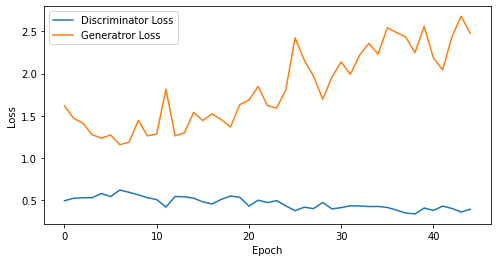

epoch: 45, Discriminator Loss: 0.4641785005728404, Generator Loss: 1.8156762573454115


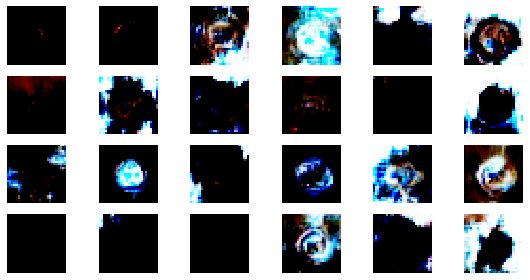

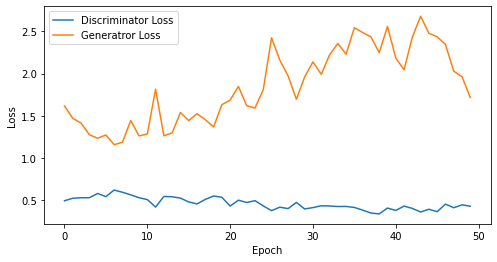

epoch: 50, Discriminator Loss: 0.459672247171402, Generator Loss: 1.843796193599701


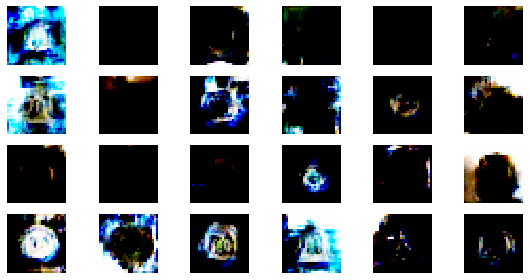

In [35]:
# discriminator와 gan 모델의 loss 측정을 위한 list 입니다.
d_losses = []
g_losses = []

for epoch in range(1, EPOCHS + 1):
    # 각 배치별 학습
    for real_images in get_batches(x_train, BATCH_SIZE): # get_batches는 x_train을 0~127, 128-255 식으로 리턴
        # 랜덤 노이즈 생성
        input_noise = np.random.uniform(-1, 1, size=[BATCH_SIZE, NOISE_DIM]) # [128, 10] 짜리 노이즈
        
        # 가짜 이미지 데이터 생성
        generated_images = generator.predict(input_noise)
        
        # Discriminator에 학습할 X 데이터 정의
        x_dis = np.concatenate([real_images, generated_images])
        
        # Discriminator에 학습할 Y 데이터 정의
        y_dis = np.zeros(2 * BATCH_SIZE)
        y_dis[:BATCH_SIZE] = 0.9 # 왜 1로 안주는지는 모르겠음
        
        # Discriminator 훈련
        discriminator.trainable = True
        d_loss = discriminator.train_on_batch(x_dis, y_dis) # fit처럼 한번에 학습하는게 아닌, 단일 배치로 학습
        


        # Gan에 학습할 noise(-1~1사이 latent space), y_gan(항상 1) 정의
        noise = np.random.uniform(-1, 1, size=[BATCH_SIZE, NOISE_DIM])
        y_gan = np.ones(BATCH_SIZE)
        
        # Discriminator의 판별 학습을 방지
        # Gan 훈련
        discriminator.trainable = False
        g_loss = gan.train_on_batch(noise, y_gan)
        
    d_losses.append(d_loss)
    g_losses.append(g_loss)
    
    if epoch == 1 or epoch % 5 == 0:
        visualize_training(epoch, d_losses, g_losses)

In [ ]:
i_path = '../input/gtsrb-german-traffic-sign/Train/1/00001_00072_00027.png'
plt.imshow(cv2.imread(i_path, -1))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size= 0.25, random_state=21)

print((X_train.shape, y_train.shape), (X_test.shape, y_test.shape))

# converting the labels into one hot encoding
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)

In [ ]:
# number of images in each class
data_dic = {}
for folder in os.listdir(cur_path):
    data_dic[folder] = len(os.listdir(cur_path + '/' + folder))

data_df= pd.Series(data_dic)
plt.figure(figsize = (15, 6))
data_df.sort_values().plot(kind = 'bar')
plt.xlabel('Classes')
plt.ylabel('Number of images')

In [ ]:
# defining model structure
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5), activation ='relu', input_shape = (30,30,3)))
model.add(Conv2D(filters = 32, kernel_size = (5,5), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(rate = 0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3), activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3), activation ='relu'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(rate = 0.25))

model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(rate = 0.5))
model.add(Dense(43, activation= 'softmax'))

# model compilation
model.compile(loss = 'categorical_crossentropy', optimizer ='adam', metrics =['accuracy'])

In [ ]:
model.summary()

In [ ]:
epochs = 5
history = model.fit(X_train, y_train, 
                   batch_size=64,
                   epochs=epochs,
                   validation_data=(X_test, y_test))

In [ ]:
y_test = pd.read_csv('../input/gtsrb-german-traffic-sign/Test.csv')

In [ ]:
plt.imshow(cv2.imread('../input/gtsrb-german-traffic-sign/Test/00000.png'))

In [ ]:
labels_test = y_test['ClassId'].values
img_test = y_test['Path'].values
test_dir = '../input/gtsrb-german-traffic-sign'
data = []
for img in img_test:
    img_path = os.path.join(test_dir, img)
#     print(img_path)
    image = cv2.imread(img_path, -1)
    image = cv2.resize(image, (30,30), interpolation = cv2.INTER_NEAREST)
    data.append(np.array(image))
    
X_test = np.array(data)

In [ ]:
pred = model.predict_classes(X_test)

print("Test accuracy: ", accuracy_score(labels_test, pred) * 100 )